Introduction

Using generative adversarial networks to generate monet-style images.

The initial dataset includes 300 monet images, and 7038 real photos, all of which are RGB and 256x256 pixels in size.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from tensorflow.random import uniform, normal
from tensorflow import GradientTape, concat, ones, zeros, shape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Reshape, Conv2DTranspose
from tensorflow.keras.metrics import Mean
from tensorflow.keras.utils import array_to_img, image_dataset_from_directory
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Input, Model

# EDA

Investigate the structure,

In [2]:
sample_img = Image.open('./gan-getting-started/monet_jpg/000c1e3bff.jpg')
#sample_img = Image.open('./gan-getting-started/photo_jpg/00068bc07f.jpg')
print(f'Width:{sample_img.width} Height:{sample_img.height} Mode: {sample_img.mode} Palette: {sample_img.palette}')

Width:256 Height:256 Mode: RGB Palette: None


300


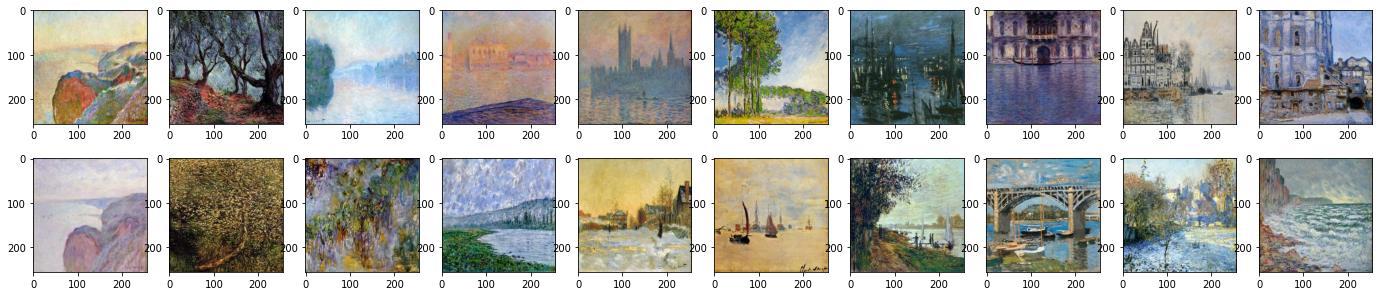

In [3]:
monets = os.listdir('./gan-getting-started/monet_jpg/')
plt.figure(figsize=(24,5))
for i,file in enumerate(monets[0:20]):
    plt.subplot(2,10,i+1)
    img = plt.imread('./gan-getting-started/monet_jpg/' + file)
    plt.imshow(img)

print(len(monets))

7038


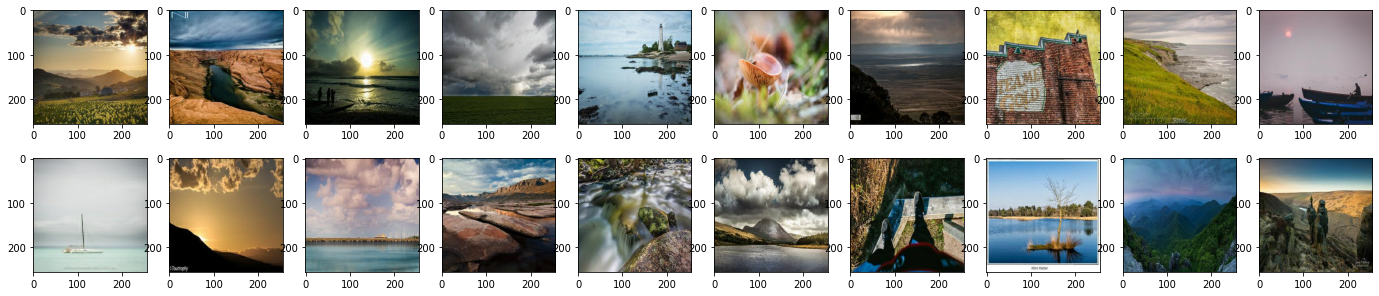

In [4]:
photos = os.listdir('./gan-getting-started/photo_jpg/')
plt.figure(figsize=(24,5))
for i,file in enumerate(photos[0:20]):
    plt.subplot(2,10,i+1)
    img = plt.imread('./gan-getting-started/photo_jpg/' + file)
    plt.imshow(img)

print(len(photos))

# Model Building

First build the discriminator and generator models

In [5]:
def get_discriminator():
    model = Sequential(name='Discriminator')
    model.add(Input(shape=(256,256,3)))
    model.add(Conv2D(256, kernel_size=4, activation='leaky_relu', strides=2, padding = 'Same'))
    model.add(Conv2D(512, kernel_size=4, activation='leaky_relu', strides=2, padding = 'Same'))
    model.add(Conv2D(512, kernel_size=4, activation='leaky_relu', strides=2, padding = 'Same'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def get_generator():
    model = Sequential(name='Generator')
    model.add(Input(shape=512,))
    model.add(Dense(32*32*512))
    model.add(Reshape((32,32,512)))
    model.add(Conv2DTranspose(512, kernel_size=4, activation='leaky_relu', strides=2, padding='Same'))
    model.add(Conv2DTranspose(512, kernel_size=4, activation='leaky_relu', strides=2, padding='Same'))
    model.add(Conv2DTranspose(512, kernel_size=4, activation='leaky_relu', strides=2, padding='Same'))
    model.add(Conv2D(3, kernel_size=5, activation='sigmoid', padding='Same'))
    return model

In [6]:
discriminator = get_discriminator()
discriminator.summary()


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     12544     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 512)       2097664   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 512)       4194816   
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dropout (Dropout)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 1)                 524289    
                                                                 
Total params: 6829313 (26.05 MB)
Trainable params: 6

In [7]:
generator = get_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 524288)            268959744 
                                                                 
 reshape (Reshape)           (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 512)       4194816   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 512)     4194816   
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 256, 256, 512)     4194816   
 Transpose)                                                      
                                                         

Load files as numpy data

In [8]:
monet_data = []

for file in monets:
    img = Image.open(f'./gan-getting-started/monet_jpg/{file}')
    monet_data.append(np.asarray(img))

In [9]:
photo_data = []

for file in photos:
    img = Image.open(f'./gan-getting-started/photo_jpg/{file}')
    photo_data.append(np.asarray(img))

Create GAN class

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = 42

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = shape(real_images)[0]
        random_latent_vectors = normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = concat(
            [ones((batch_size, 1)), zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * uniform(shape(labels))

        # Train the discriminator
        with GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [11]:
class GANMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = 42

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [12]:
dataset = image_dataset_from_directory('./gan-getting-started/monet_jpg/', label_mode=None, image_size=(256,256), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


In [14]:
epochs = 50
latent_dim=512

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0001),
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])